In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# From local helper files
from helper_evaluation import set_all_seeds, set_deterministic
from helper_train import train_model
from helper_plotting import plot_training_loss, plot_accuracy, show_examples
from helper_dataset import get_dataloaders_mnist

In [ ]:
train_loader, valid_loader, test_loader = get_dataloaders_mnist(
    batch_size=128,
    validation_fraction=0.1)

# Checking the dataset
for images, labels in train_loader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels[:10])
    break

Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])
Class labels of 10 examples: tensor([2, 3, 4, 6, 2, 1, 9, 3, 9, 7])


## 1. Normalising the data for this network

In [ ]:
class MultilayerPerceptron():

    def __init__(self, num_features, num_hidden, num_classes):
        super(MultilayerPerceptron, self).__init__()

        self.num_classes = num_classes

        # hidden 1
        self.weight_1 = torch.zeros(num_hidden, num_features,
                                    dtype=torch.float).uniform_(0.0, 1.0)
        self.bias_1 = torch.zeros(num_hidden, dtype=torch.float)

        # output
        self.weight_o = torch.zeros(self.num_classes, num_hidden,
                                    dtype=torch.float).uniform_(0.0, 1.0)
        self.bias_o = torch.zeros(self.num_classes, dtype=torch.float)

    def forward(self, x):
        # hidden 1

        # input dim: [n_hidden, n_features] dot [n_features, n_examples] .T
        # output dim: [n_examples, n_hidden]
        z_1 = torch.mm(x, self.weight_1.t()) + self.bias_1
        mean_of_z1 = z_1.mean(dim=0)
        std_of_z1 = z_1.std(dim=0)
        normalised_data = (z_1 - mean_of_z1) / std_of_z1
        a_1 = torch.sigmoid(normalised_data)

        # hidden 2
        # input dim: [n_classes, n_hidden] dot [n_hidden, n_examples] .T
        # output dim: [n_examples, n_classes]
        z_2 = torch.mm(a_1, self.weight_o.t()) + self.bias_o
        a_2 = torch.sigmoid(z_2)
        return a_1, a_2

In [ ]:
model = MultilayerPerceptron(num_features=28*28,
                             num_hidden=15,
                             num_classes=10)



In [ ]:
train_loader_list = list(train_loader)
features, target = train_loader_list[0]
a1, a2 = model.forward(features.view(-1,28 * 28))


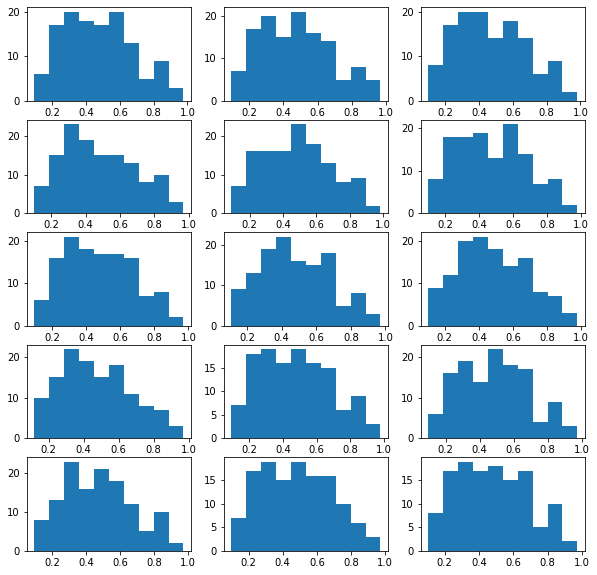

In [ ]:
fig, axs = plt.subplots(5, 3)
fig.set_figheight(10)
fig.set_figwidth(10)
x = np.arange(128)
cnt = 0
for i in range(5):
  for j in range(3):
    axs[i, j].hist(a1[:, cnt])
    cnt += 1













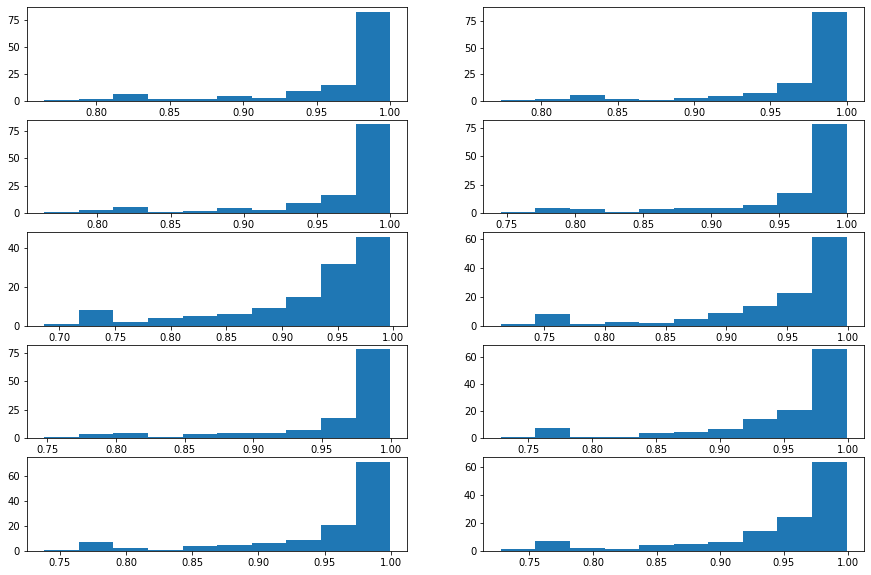

In [ ]:
fig, axs = plt.subplots(5, 2)
fig.set_figheight(10)
fig.set_figwidth(15)
x = np.arange(128)
cnt = 0
for i in range(5):
  for j in range(2):
    axs[i, j].hist(a2[:, cnt])
    cnt += 1






## Plotting without normalisation

In [ ]:
class MultilayerPerceptronWithout():

    def __init__(self, num_features, num_hidden, num_classes):
        super(MultilayerPerceptronWithout, self).__init__()

        self.num_classes = num_classes

        # hidden 1
        self.weight_1 = torch.zeros(num_hidden, num_features,
                                    dtype=torch.float).uniform_(0.0, 1.0)
        self.bias_1 = torch.zeros(num_hidden, dtype=torch.float)


        # output
        self.weight_o = torch.zeros(self.num_classes, num_hidden,
                                    dtype=torch.float).uniform_(0.0, 1.0)
        self.bias_o = torch.zeros(self.num_classes, dtype=torch.float)

    def forward(self, x):
        # hidden 1

        # input dim: [n_hidden, n_features] dot [n_features, n_examples] .T
        # output dim: [n_examples, n_hidden]
        z_1 = torch.mm(x, self.weight_1.t()) + self.bias_1
        a_1 = torch.sigmoid(z_1)

        # hidden 2
        # input dim: [n_classes, n_hidden] dot [n_hidden, n_examples] .T
        # output dim: [n_examples, n_classes]
        z_2 = torch.mm(a_1, self.weight_o.t()) + self.bias_o
        a_2 = torch.sigmoid(z_2)
        return a_1, a_2

In [ ]:
model = MultilayerPerceptronWithout(num_features=28*28,
                             num_hidden=15,
                             num_classes=10)


In [ ]:
train_loader_list = list(train_loader)
features, target = train_loader_list[0]
a1, a2 = model.forward(features.view(-1,28 * 28))


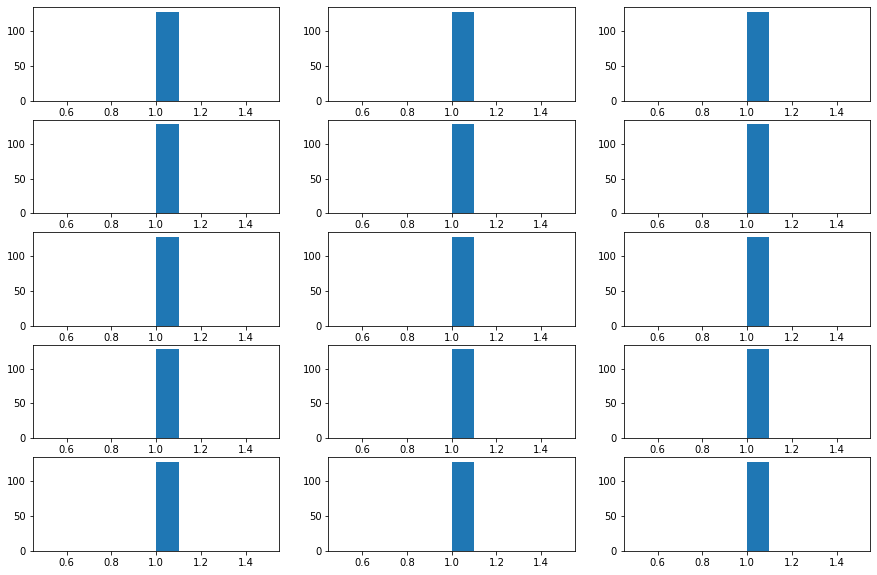

In [ ]:
fig, axs = plt.subplots(5, 3)
fig.set_figheight(10)
fig.set_figwidth(15)
cnt = 0
for i in range(5):
  for j in range(3):
    axs[i, j].hist(a1[:, cnt])
    cnt += 1



















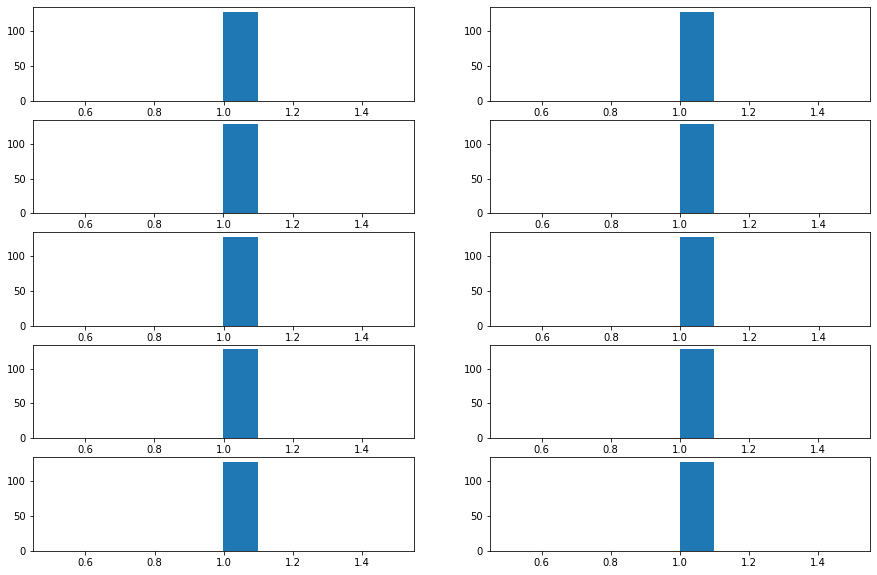

In [ ]:
fig, axs = plt.subplots(5, 2)
fig.set_figheight(10)
fig.set_figwidth(15)
cnt = 0
for i in range(5):
  for j in range(2):
    axs[i, j].hist(a2[:, cnt])
    cnt += 1


















## After applying batchnorm we can see that, the data is distributed, in case of not applying batch norm, the net iputs were all positive and therefore sigmoid made it all 1.

## With normalisation, we can see that the a1 and a2 values are distributed well and not just all 1s.

## 2. Updating the code for using it with inference

In [ ]:
class MultilayerPerceptronWithMovingAverage():

    def __init__(self, num_features, num_hidden, num_classes, momentum):
        super(MultilayerPerceptronWithMovingAverage, self).__init__()

        self.num_classes = num_classes

        self.weight_1 = torch.zeros(num_hidden, num_features,
                                    dtype=torch.float).uniform_(0.0, 1.0)
        self.bias_1 = torch.zeros(num_hidden, dtype=torch.float)

        self.weight_o = torch.zeros(self.num_classes, num_hidden,
                                    dtype=torch.float).uniform_(0.0, 1.0)
        self.bias_o = torch.zeros(self.num_classes, dtype=torch.float)


        self.momentum = momentum

        # moving average
        self.moving_average = torch.zeros(num_hidden, dtype=torch.float)

        # moving standard deviation
        self.moving_standard_deviation = torch.zeros(num_hidden, dtype=torch.float)


    def forward(self, x, test=False):
        z_1 = torch.mm(x, self.weight_1.t()) + self.bias_1

        if not test:
          mean_of_z1 = z_1.mean(dim=0)
          std_of_z1 = z_1.std(dim=0)

        if not test:
          normalised_data = (z_1 - mean_of_z1) / std_of_z1
        else:
          normalised_data = (z_1 - self.moving_average) / self.moving_standard_deviation

        a_1 = torch.sigmoid(normalised_data)

        if not test:
          # Updating the moving_average values based on mean_of_z1
          self.moving_average = self.momentum * (self.moving_average) + (1 - self.momentum) * mean_of_z1
          # Updating the moving_average values based on std_of_z1
          self.moving_standard_deviation = self.momentum * (self.moving_standard_deviation) + (1 - self.momentum) * std_of_z1


        z_2 = torch.mm(a_1, self.weight_o.t()) + self.bias_o
        a_2 = torch.sigmoid(z_2)
        return a_1, a_2

In [ ]:
model = MultilayerPerceptronWithMovingAverage(num_features=28*28,
                             num_hidden=15,
                             num_classes=10,
                             momentum=0.1)

In [ ]:
train_loader_list = list(train_loader)
features, target = train_loader_list[0]
a1, a2 = model.forward(features.view(-1,28 * 28))


In [ ]:
model.moving_average

tensor([46.6290, 44.9483, 48.9646, 45.4115, 48.1639, 45.4521, 45.4954, 47.3481,
        48.9704, 46.0026, 50.9311, 49.8487, 50.9078, 47.6156, 47.4762])

In [ ]:
model.moving_standard_deviation

tensor([14.5950, 14.1369, 15.6731, 14.3643, 15.2127, 14.9167, 15.1798, 14.9895,
        16.6470, 15.2006, 16.1493, 16.2587, 15.6886, 15.4498, 15.2196])

In [ ]:
test_loader_list = list(test_loader)
features, target = test_loader_list[0]
a1, a2 = model.forward(features.view(-1,28 * 28), True)


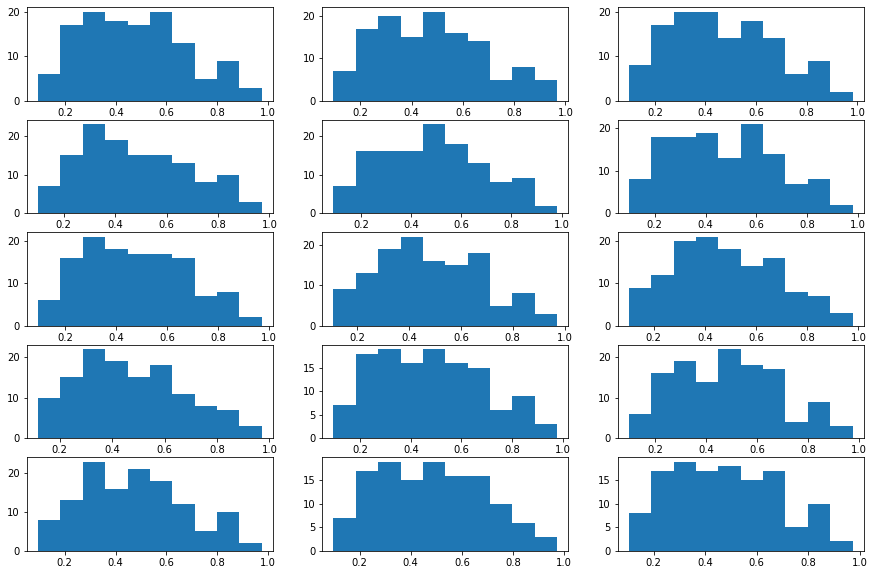

In [ ]:
fig, axs = plt.subplots(5, 3)
fig.set_figheight(10)
fig.set_figwidth(15)
cnt = 0
for i in range(5):
  for j in range(3):
    axs[i, j].hist(a1[:, cnt])
    cnt += 1




















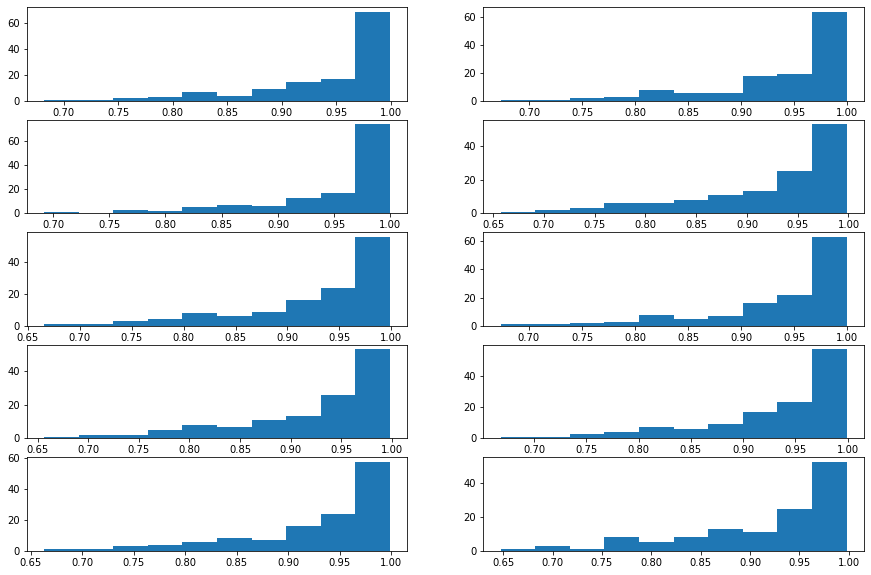

In [ ]:
fig, axs = plt.subplots(5, 2)
fig.set_figheight(10)
fig.set_figwidth(15)
cnt = 0
for i in range(5):
  for j in range(2):
    axs[i, j].hist(a2[:, cnt])
    cnt += 1



















